In [1]:
import hdbscan 
import zarr
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import metrics# import adjusted_rand_score, adjusted_mutual_info_score,silhouette_score
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
zarr_path = "/media/microscopie-lcb/swapnesh/protein/embeddings/phages/1Sept2024_INPHARED_db_latest/ESM2_650m_1Sept24_650m.zarr"
zarr_store = zarr.open(zarr_path,'r')
vectors = zarr_store['vectors_mean'][:]
accessions = zarr_store['accessions'][:]
vectors.shape

(24362, 1280)

In [ ]:
# Perform clustering
dist_scaled = euclidean_distances(vectors).astype("double")
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,
    n_jobs=32,
    min_samples=1,
    allow_single_cluster=False,
    cluster_selection_method="leaf",
    metric="precomputed",
    gen_min_span_tree=True
)
clusterer.fit(dist_scaled)


In [ ]:
eps_range = np.linspace(8e-3,4e-2,1024)
stability_scores = []
labels_prev = clusterer.dbscan_clustering(cut_distance=eps_range[0],min_cluster_size=2)
for eps in tqdm(eps_range):
    labels = clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2)
    mi = metrics.mutual_info_score(labels_prev,labels)
    idx = labels > -1
    sil_score = metrics.silhouette_score(vectors[idx],labels[idx])
    stability_scores += [[mi,sil_score]]
    labels_prev = labels
stability_scores = np.array(stability_scores)    
# Find eps values with high stability
plt.plot(eps_range,stability_scores[:,0])
plt.plot(eps_range,stability_scores[:,1])
plt.show()
best_stability_index = np.argmax(stability_scores[:,0]) # use mutual infor
best_eps = eps_range[best_stability_index]
    

In [169]:
genus_eps = best_eps
best_eps

0.02412903225806452

In [188]:
eps_range = np.linspace(8e-3,4e-2,512)
eps_range = np.linspace(1e-2,5e-2,512)
labels_prev = clusterer.labels_
stability_scores = []

from joblib.parallel import delayed,Parallel

# def scoring_func(eps):
#     labels = clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2)
#     ami = adjusted_mutual_info_score(labels_prev,labels)
#     ari = adjusted_rand_score(labels_prev,labels)
#     return [ami,ari]
# stability_scores = Parallel(32)([scoring_func(eps) for eps in tqdm(eps_range)])

stability_scores = []
labels_prev = clusterer.dbscan_clustering(cut_distance=genus_eps,min_cluster_size=2)
idx=labels_prev>-1
for eps in tqdm(eps_range):
    labels = clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2)
    ami = metrics.adjusted_mutual_info_score(labels_prev[idx],labels[idx])
    ari = metrics.adjusted_rand_score(labels[idx],labels_prev[idx])
    ri = metrics.rand_score(labels_prev[idx],labels[idx])
    mi = metrics.mutual_info_score(labels_prev[idx],labels[idx])
    #sil_score = silhouette_score(vectors,labels)
    stability_scores += [[ari,ami,ri,mi]]
    #labels_prev = labels

stability_scores = np.array(stability_scores)    
stability_scores.shape

  0%|          | 0/512 [00:00<?, ?it/s]

100%|██████████| 512/512 [05:10<00:00,  1.65it/s]


(512, 4)

Best eps for stable clustering: 0.02416829745596869


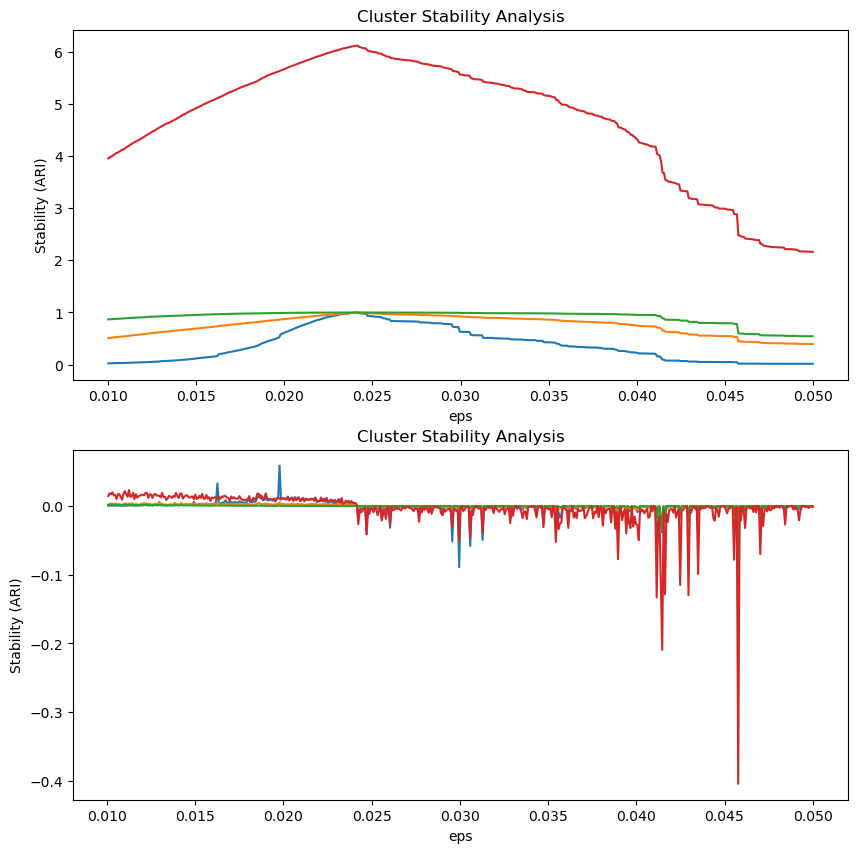

In [189]:
# Find eps values with high stability
best_stability_index = np.argmax(stability_scores[:,3])
best_eps = eps_range[best_stability_index]

print(f"Best eps for stable clustering: {best_eps}")

# Plot stability scores
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
for i in range(stability_scores[:,:].shape[-1]):
    plt.plot(eps_range, stability_scores[:,i])

plt.xlabel("eps")
plt.ylabel("Stability (ARI)")
plt.title("Cluster Stability Analysis")
plt.subplot(2,1,2)
for i in range(stability_scores.shape[-1]):
    plt.plot(eps_range[1:], np.diff(stability_scores[:,i]))

plt.xlabel("eps")
plt.ylabel("Stability (ARI)")
plt.title("Cluster Stability Analysis")
plt.show()

In [ ]:
import networkx as nx
def make_network(hdb, df, wt_nan=1e12):
    G = nx.DiGraph()
    for row in hdb.condensed_tree_._raw_tree:
        if np.isfinite(row['lambda_val']):
            w = row['lambda_val']
            #row['distance'] = 1 / row['lambda_val']  # Add distance attribute
            
        else:
            w = wt_nan
        G.add_edge(int(row['parent']), int(row['child']), weight=w)

    # Assign attributes to existing nodes
    for i, (idx, row) in enumerate(df.iterrows()):
        nodeId = int(i)
        G.nodes(data=True)[nodeId].update(row.to_dict())
    return G
import pandas as pd
df = pd.DataFrame({'Labels':clusterer.dbscan_clustering(cut_distance=0.04580645,min_cluster_size=2)})
G = make_network(clusterer,df)
nx.write_gexf(G,zarr_path + '.gexf')
df = pd.DataFrame({'Labels1':clusterer.dbscan_clustering(cut_distance=0.02412903225806452,min_cluster_size=2),'Accession':zarr_store['accessions'][:]})
df.to_csv(zarr_path + '.csv')

In [191]:
tmp = {f'Labels_{i}':clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2) for i,eps in enumerate(opt_eps)}
df = pd.DataFrame(tmp)
df['Accession'] = zarr_store['accessions'][:]
df.to_csv(zarr_path + '.csv')

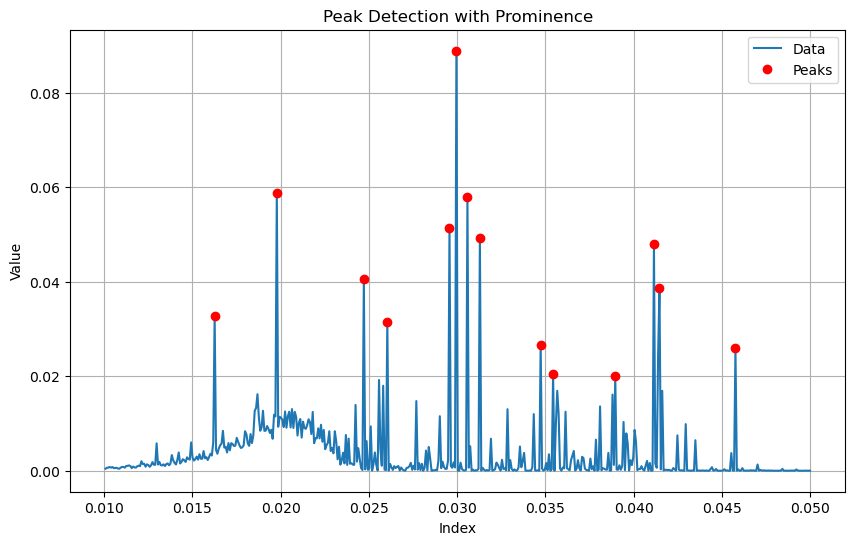

In [190]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def find_and_plot_peaks(x,data, prominence=1.0):
    """
    Find peaks in a 1D array based on prominence and plot the results.

    Parameters:
        data (array-like): The input 1D data array.
        prominence (float): The required prominence of peaks.

    Returns:
        peaks (array): Indices of the peaks in the data.
        properties (dict): Properties of the peaks (from scipy.signal.find_peaks).
    """
    # Find peaks with the specified prominence
    peaks, properties = find_peaks(data, prominence=prominence)

    # Plot the data and highlight the peaks
    plt.figure(figsize=(10, 6))
    plt.plot(x,data, label="Data", linewidth=1.5)
    plt.plot(x[peaks], data[peaks], "ro", label="Peaks")
    
    # Annotate peaks with their prominence values
    for peak, prom in zip(peaks, properties['prominences']):
        plt.annotate(f'{prom:.2f}', (peak, data[peak]),
                     textcoords="offset points", xytext=(0, 10), ha='center')

    plt.title("Peak Detection with Prominence")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

    return x[peaks], properties

opt_eps,_=find_and_plot_peaks(eps_range[1:],np.abs(np.diff(stability_scores[:,0])), prominence=0.02)


In [91]:
# Extract lambda values for prominent clusters
condensed = clusterer.condensed_tree_.to_pandas()
prominent_clusters = condensed[(condensed['child_size'] > 32) & (condensed['child_size'] < 64)]  # Clusters with significant size
lambda_vals = prominent_clusters['lambda_val']
child_size = prominent_clusters['child_size']

# Convert lambda values to eps candidates
eps_candidates = 1 / lambda_vals
print(f"Candidate eps values: {eps_candidates}")

Candidate eps values: 73       0.145830
283      0.124899
289      0.051854
293      0.033397
532      0.114809
           ...   
35934    0.004623
35948    0.004465
35961    0.004378
35985    0.004295
35992    0.004258
Name: lambda_val, Length: 657, dtype: float64


In [112]:
condensed = clusterer.condensed_tree_.to_pandas()
prominent_clusters = condensed[(condensed['child_size'] > 2)]  # Clusters with significant size
lambda_vals = prominent_clusters['lambda_val']
child_size = prominent_clusters['child_size']
prominent_clusters['distance'] = 1/lambda_vals
prominent_clusters

/tmp/ipykernel_2401667/4073425299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prominent_clusters['distance'] = 1/lambda_vals


,parent,child,lambda_val,child_size,distance
3,24362,24363,4.877057,24357,0.205042
5,24363,24365,4.884631,24355,0.204724
12,24365,24367,5.146198,24352,0.194318
26,24367,24369,6.168518,24320,0.162114
27,24367,24370,6.168518,22,0.162114
...,...,...,...,...,...
36022,36037,36040,277.368991,3,0.003605
36026,36039,36042,278.352530,10,0.003593
36030,36042,36043,290.389835,8,0.003444
36037,36043,36045,300.757824,4,0.003325


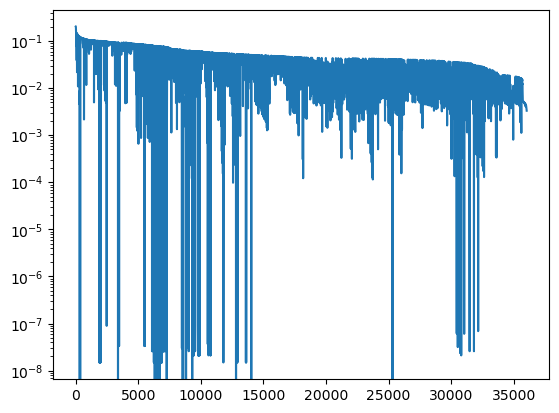

In [127]:
plt.semilogy(prominent_clusters['distance'])

In [119]:
parent_nodes = set(prominent_clusters['parent'])
stats = []
for p in parent_nodes:
    idx = prominent_clusters['parent'] ==p
    total_childern = prominent_clusters[idx]['child_size'].sum()
    distance_mean = prominent_clusters[idx]['distance'].mean()
    distance_std = np.nanstd(prominent_clusters[idx]['distance'])
    stats += [[distance_mean,distance_std,total_childern]]
stats = np.array(stats)
stats.shape

(5475, 3)

In [120]:
distance_std

0.0

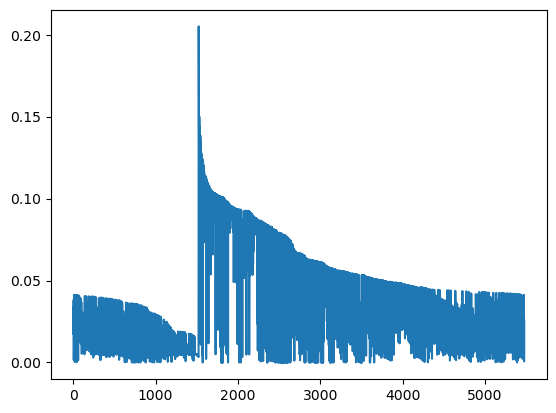

In [122]:
plt.plot(stats[:,0])

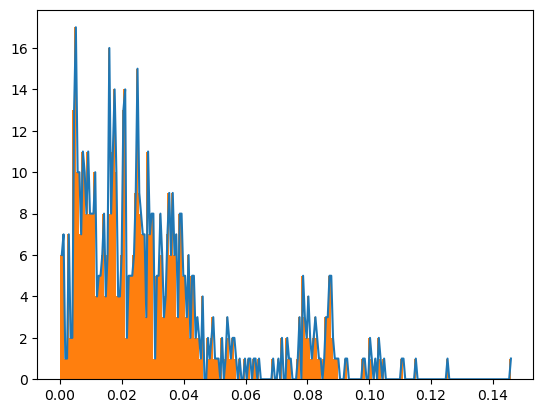

In [92]:
binsize = 256
h,b = np.histogram(eps_candidates,binsize,density=False)
plt.plot(b[1:],h)
plt.hist(eps_candidates,binsize);

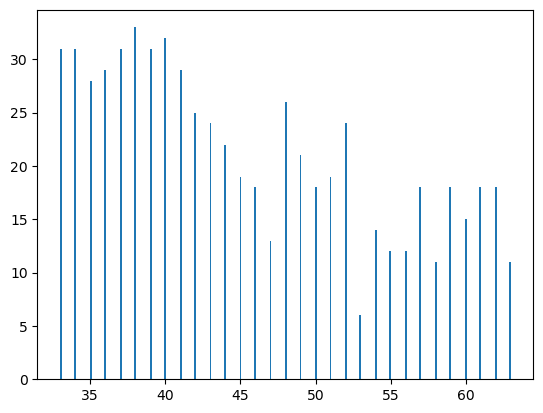

In [93]:
plt.hist(child_size,binsize);

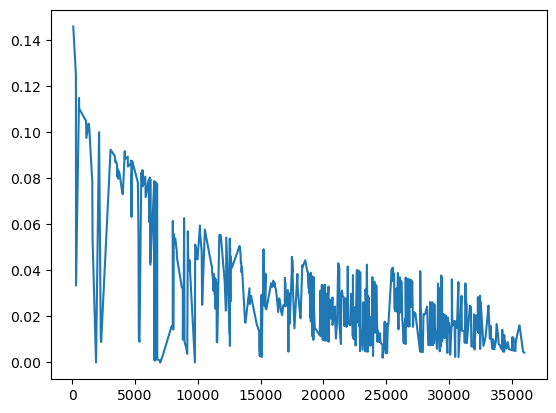

In [94]:
plt.plot(eps_candidates)

In [53]:

stability_scores = []
labels_prev = clusterer.dbscan_clustering(cut_distance=eps_range[0],min_cluster_size=2)
for eps in tqdm(eps_candidates):
    labels = clusterer.dbscan_clustering(cut_distance=eps,min_cluster_size=2)
    ami = adjusted_mutual_info_score(labels_prev,labels)
    ari = adjusted_rand_score(labels_prev,labels)
    #sil_score = silhouette_score(vectors,labels)
    stability_scores += [[ari,ami]]
    #labels_prev = labels

stability_scores = np.array(stability_scores)    
stability_scores.shape

100%|██████████| 1176/1176 [04:19<00:00,  4.54it/s]


(1176, 2)

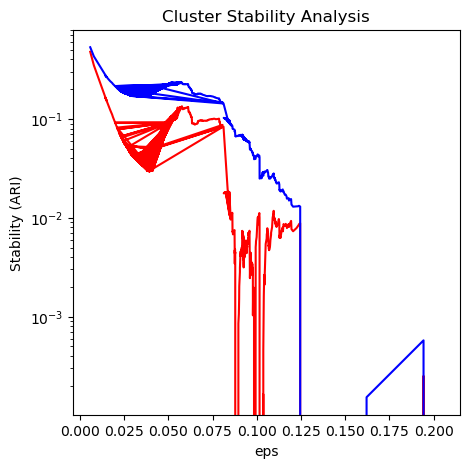

In [56]:
# Plot stability scores
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.semilogy(eps_candidates, stability_scores[:,0],'r')
plt.semilogy(eps_candidates, stability_scores[:,1],'b')
plt.xlabel("eps")
plt.ylabel("Stability (ARI)")
plt.title("Cluster Stability Analysis")
plt.show()